# HiSC
sample datasets first, Enzymes dataset below

In [1]:
# load HiSC functions
from HiSC_max import process_csv, HiSC, reachability_plot, get_clusters


In [2]:
# working sample datasets
# data, labels_true = process_csv("../../test_data/3-gaussian-3d-adj.csv")
# alpha = 0.007
# k = 4

data, labels_true = process_csv("../../test_data/subspaces-5d-adj.csv")
alpha = 0.02
k = 4

# data, labels_true = process_csv("../../test_data/SpiralData2_very_noisy_2.csv", sep=",")
# alpha = 0.015
# k = 2

# data, labels_true = process_csv("../../test_data/DS1.txt", sep=" ")
# alpha = 0.0015
# k = 2

clus_ord = HiSC(data, alpha, k, verbose=False, elki=True)

# for p in clus_ord[:]:
#     print(p)    

Running HiSC, input dataset has 700 entries with 5 dimensions


[0.30029718 0.4589123  0.20188381]


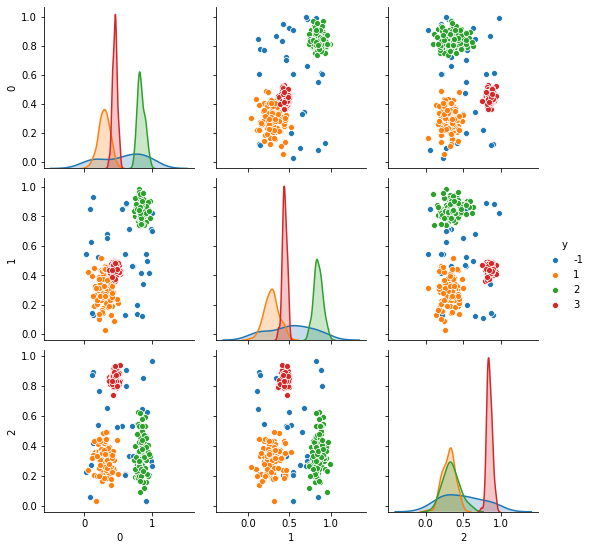

In [60]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(data=data)
df["y"] = labels_true

sns.pairplot(df, vars=df.columns[:-1], hue="y")



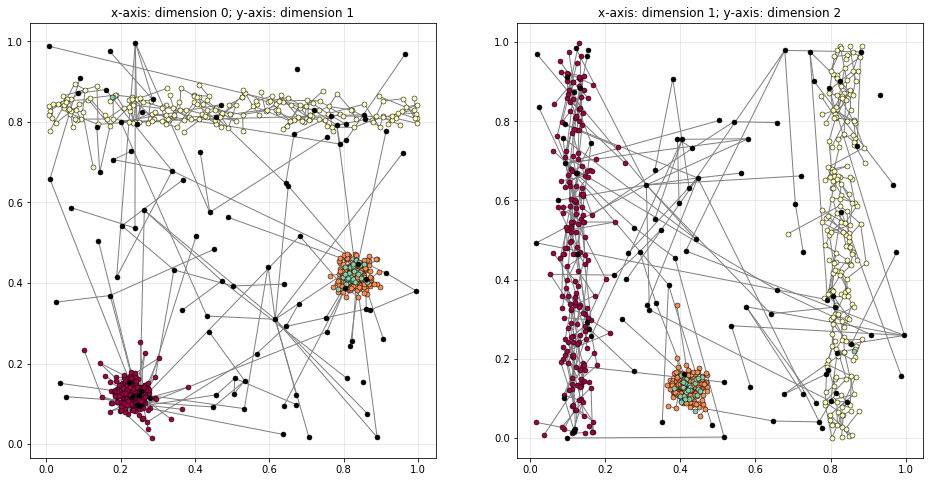

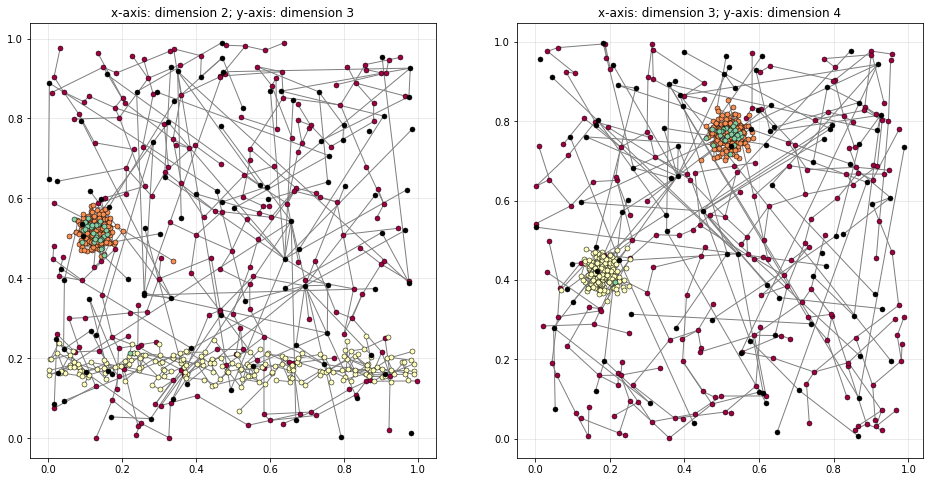

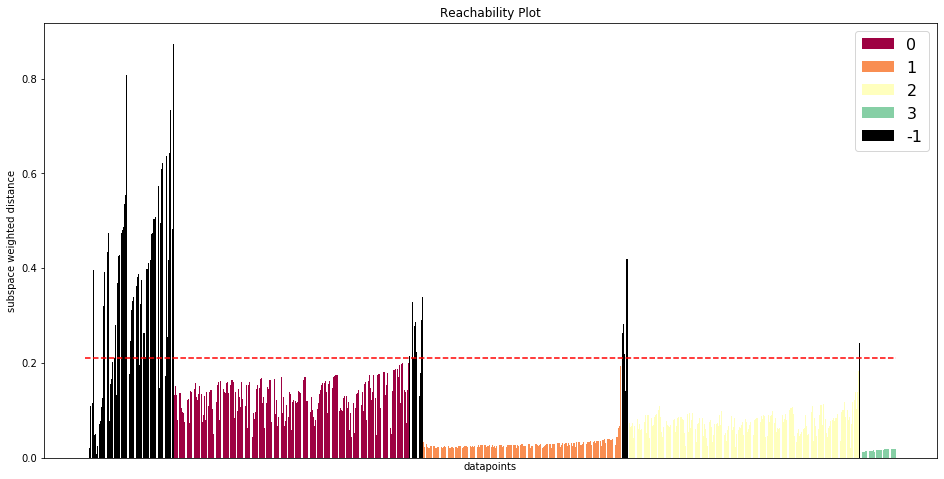

In [3]:
threshold=0.21
n_cluster = 99 # doesnt do anything for the time being

labels = get_clusters(clus_ord, threshold=threshold)

plot_dimensions = [(0,1),(1,2),(2,3),(3,4)]
reachability_plot(data, clus_ord, labels, threshold, dimensions=plot_dimensions)

In [194]:
def reachability_plot(data, cluster_order, labels_true, labels_of_data, threshold, n_cluster):
    

    for i, point in enumerate(cluster_order):
        point.label = labels_of_data[i]
        

#     print('Estimated number of clusters: %d' % n_clusters_)

#     print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_of_data))
#     print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_of_data))
#     print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_of_data))
#     print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_of_data))
#     print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels_of_data))
#     print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels_of_data))

    # ground truth plot
    plt.figure(figsize=(16, 7))
    plt.subplot(1, 2, 1)
    unique_labels = set(labels_true) # warum steht da set?
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == 'Noise':
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels_true == k)

        xy = data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)
    ax = plt.gca()
#     ax.set_facecolor('gray')
    plt.title('Ground Truth %d' % len(unique_labels))
    plt.grid(True, alpha=0.5)

    
    
    
    # plot with our labels
    plt.subplot(1, 2, 2)

        
        
    line_plot = []    
    for i, point in enumerate(cluster_order):             
        if point.distance <= 0.0:
            continue               
        point_xdim = data[point.id][0]
        point_ydim = data[point.id][1]        
        point_pred_xdim = data[point.predecessor][0]
        point_pred_ydim = data[point.predecessor][1]        
        line_plot.append((point_xdim, point_ydim, point_pred_xdim, point_pred_ydim))
    
    # Get the current Axes instance 
    ax = plt.gca()

    for x1, y1, x2, y2 in line_plot:
        line = lines.Line2D([x1, x2], [y1, y2],
                        lw=1, color='gray', axes=ax)
        ax.add_line(line)
    
    
    unique_labels = set(labels_of_data) 
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels_of_data == k)
        xy = data[class_member_mask]        
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgewidth=0.5, markeredgecolor='k', markersize=5)
    
#     line = lines.Line2D([0.3, 0], [0.45, 0],
#                         lw=2, color='black', axes=ax)
#     ax.add_line(line)
    
    
#     ax.set_facecolor('gray')
    plt.title(f'Estimated number of clusters: {len(set(labels_of_data))}')
    plt.grid(True)
    
         

    # plot reachability
    plt.figure(figsize=(16, 7))
    
    unique_labels = set(labels_of_data)
    unique_labels = set(labels_true)
    
    # using the spectral colourmap
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    
    sequence = []
    subspaceDim = []
    
    for label, color in zip(unique_labels, colors):        
        label = int(label)
        
        if(label == -1):
            color = (0, 0, 0, 1)
        for i, point in enumerate(cluster_order):     
            
            if(int(labels_true[point.id]) == label):
                sequence.append(i)
                subspaceDim.append(point.distance)

                
                
        plt.bar(sequence, subspaceDim, color=tuple(color), label=label)
        
        sequence = []
        subspaceDim = []
        

    ax = plt.gca()
    ax.set_facecolor('gray')
    plt.title('Reachability')   
    plt.grid(False)  
    plt.plot(np.arange(len(data)), [threshold] * len(data), '--', color='red')
    plt.xticks([]) # remove x axis labels - too much information
    plt.xlabel('datapoints')
    plt.ylabel('subspace weighted distance')
    plt.legend()
    plt.show()

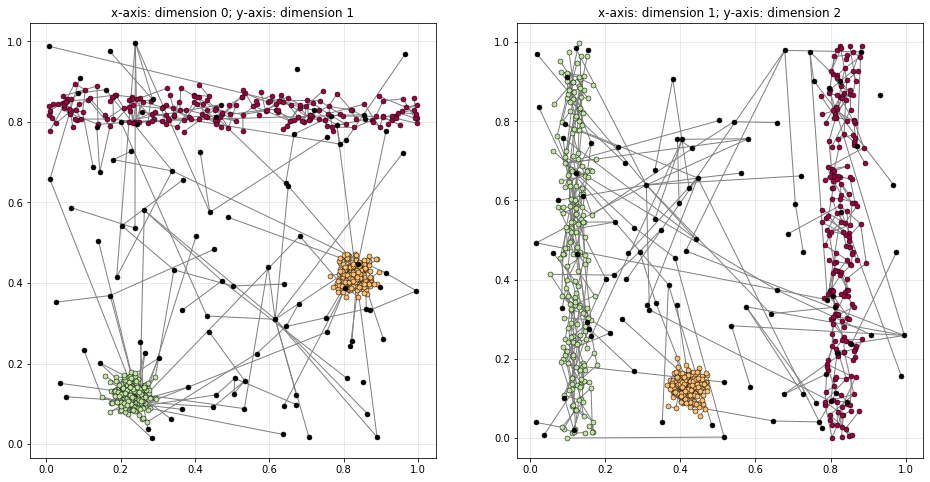

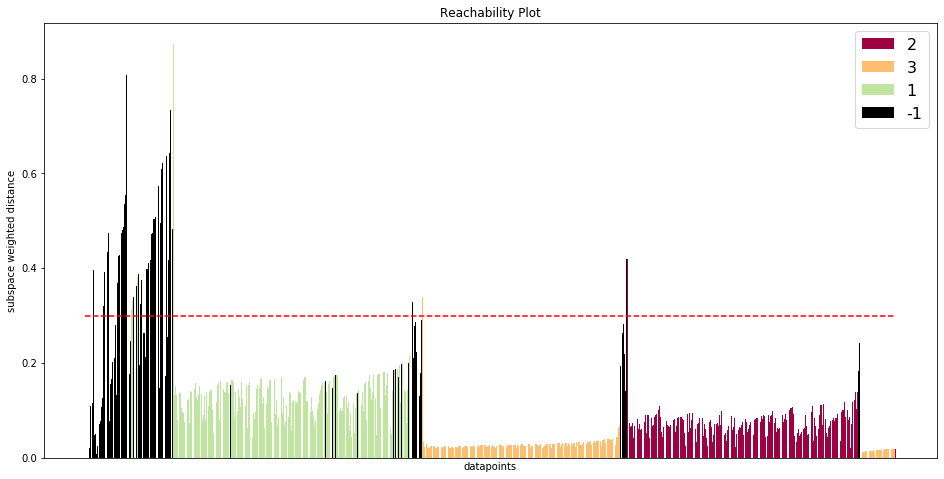

In [201]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches


from dataclasses import dataclass, field
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics

threshold=0.3
n_cluster = 99 # doesnt do anything for the time being

labels = get_clusters(clus_ord, threshold=threshold)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_of_data))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels_of_data))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_of_data))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels_of_data))
# print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels_of_data))
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data, labels_of_data))

# reachability_plot(data, clus_ord, labels, threshold, n_cluster)
reachability_plot(data, clus_ord, labels_true, threshold)
# print (labels_true)

In [28]:
# this reads X and y from different filenames

# dataset_file = "../../test_data/ENZYMES_gram_matrix_wl5.csv"
dataset_file = "../../test_data/ENZYMES_gram_matrix_wl4_filtered.csv"
# label_file = "../../test_data/ENZYMES_graph_labels.txt"
label_file = "../../test_data/ENZYMES_graph_labels_filtered.txt"
data, labels_true = process_csv(dataset_file, input_filename_labels=label_file, sep=";")

len (labels), len(labels_true)

(488, 488)

# Enzymes dataset

In [31]:
# this takes 5-10 seconds for the enzymes WL5 dataset

alpha = 0.007
k = 4
clus_ord = HiSC(data, alpha, k, verbose=False, elki=True)

print()
# print first 20 entries
for p in clus_ord[0:20]:
    print(p)    

Running HiSC, input dataset has 488 entries with 488 dimensions
Computing hierarchical structure |████████████████████| 100.0% complete
id:     0, pred:     0, subs:  4, dist: 0.00000, label:    -1
id:   385, pred:     0, subs: 44, dist: 5.09599, label:    -1
id:   293, pred:     0, subs: 26, dist: 6.43531, label:    -1
id:   119, pred:     0, subs: 14, dist: 3.36254, label:    -1
id:   250, pred:     0, subs: 13, dist: 6.10057, label:    -1
id:   102, pred:   119, subs: 12, dist: 0.86279, label:    -1
id:   118, pred:     0, subs: 12, dist: 2.68855, label:    -1
id:   292, pred:     0, subs: 12, dist: 4.25268, label:    -1
id:   106, pred:   292, subs: 12, dist: 0.67704, label:    -1
id:   371, pred:   250, subs: 11, dist: 0.75112, label:    -1
id:   372, pred:   106, subs: 11, dist: 0.78509, label:    -1
id:   211, pred:     0, subs: 11, dist: 1.15849, label:    -1
id:   197, pred:     0, subs: 11, dist: 3.23322, label:    -1
id:    91, pred:     0, subs: 11, dist: 3.89971, label:   

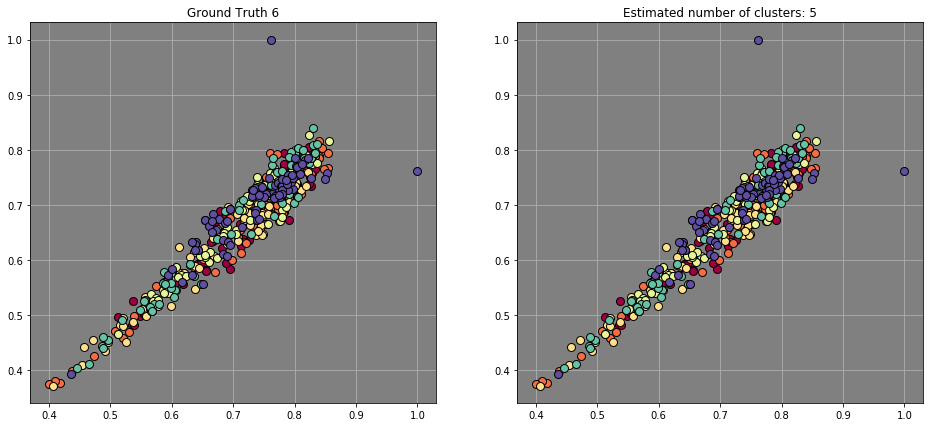

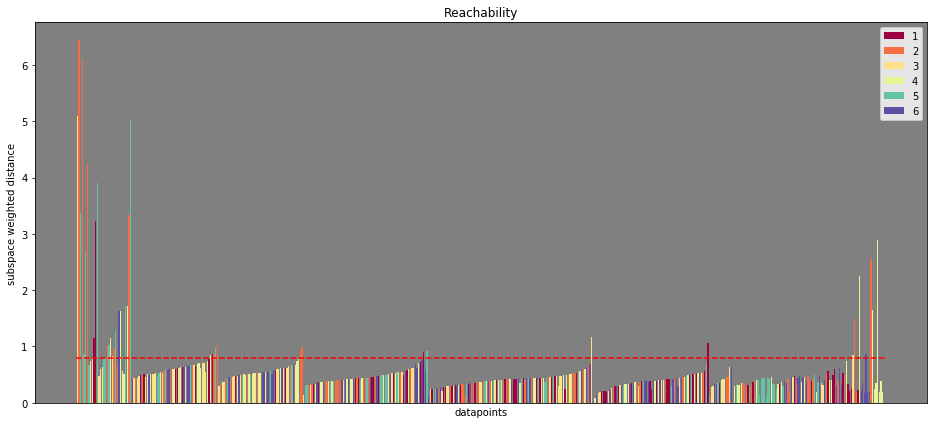

In [30]:
threshold=0.8
n_cluster = 99 # doesnt do anything for the time being

labels = get_clusters(clus_ord, threshold=threshold)

reachability_plot(data, clus_ord, labels_true, labels_true, threshold, n_cluster)

In [21]:
from sklearn import cluster, datasets, mixture

# sklearn examples as input 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-download-auto-examples-cluster-plot-cluster-comparison-py

n_samples = 400
noisy_moons_X, noisy_moons_y = datasets.make_moons(n_samples=n_samples, noise=.05)

In [52]:
noisy_moons_X

alpha = 0.003
k = 2

clus_ord = HiSC(noisy_moons_X, alpha, k, verbose=False, elki=True)

for p in clus_ord[0:10]:
    print(p)    
    
labels = get_clusters(clus_ord, threshold=threshold)

id:     0, pred:     0, subs:  0, dist: 0.00000, label:    -1
id:   144, pred:     0, subs:  2, dist: 2.72962, label:    -1
id:    50, pred:   144, subs:  2, dist: 0.04013, label:    -1
id:   308, pred:     0, subs:  1, dist: 0.02622, label:    -1
id:   114, pred:   308, subs:  1, dist: 0.03938, label:    -1
id:    91, pred:   114, subs:  1, dist: 0.01407, label:    -1
id:   297, pred:    91, subs:  1, dist: 0.01174, label:    -1
id:   394, pred:   297, subs:  1, dist: 0.01712, label:    -1
id:   295, pred:   394, subs:  1, dist: 0.01950, label:    -1
id:   125, pred:   295, subs:  1, dist: 0.02542, label:    -1


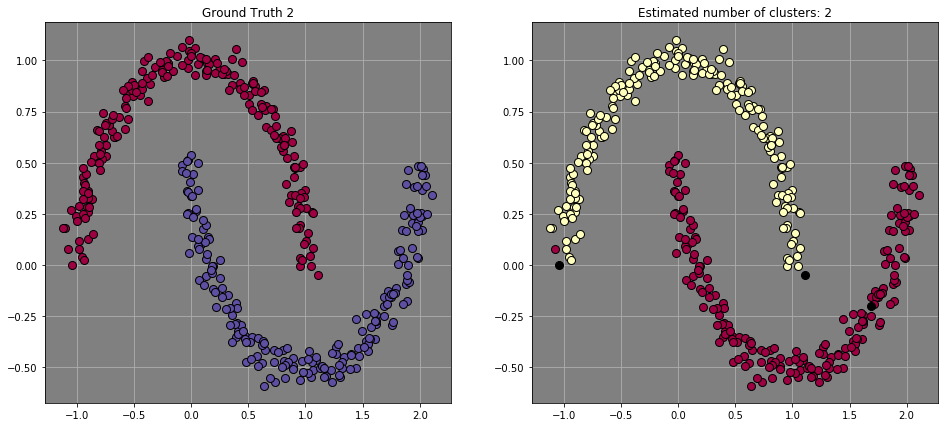

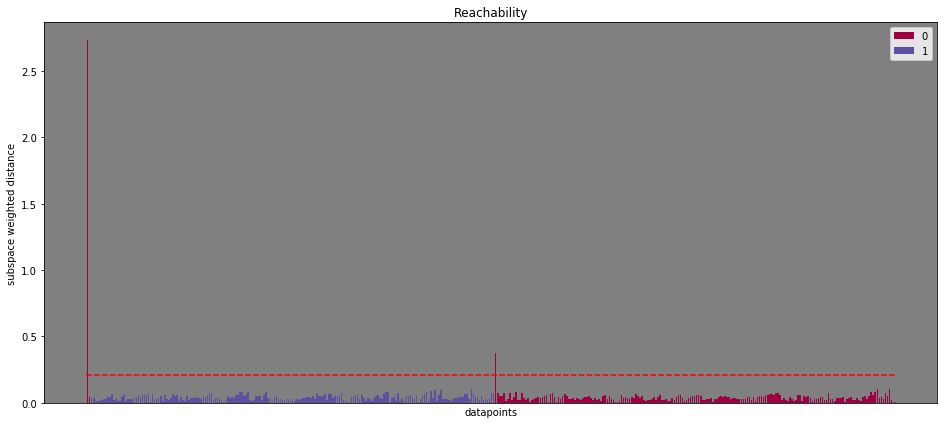

In [53]:
reachability_plot(noisy_moons_X, clus_ord, noisy_moons_y, labels, threshold, n_cluster)